# Dataset Prepration and loading

Below cells sets up the dataset and data loaders for the Pix2Pix model using the Cityscapes dataset. It includes the following steps:

1. Import necessary libraries and modules.
2. Set random seeds for reproducibility.
3. Define the directory paths for training and validation data.
4. Create a custom dataset class `Pix2PixDataset` to handle image loading and preprocessing.
5. Define image transformations: resizing, converting to tensor, and normalizing.
6. Instantiate the dataset objects for training and validation sets.
7. Create data loaders for batching and shuffling the data.
8. Display three sample images from the training set, showing both the segmented input and the real target images.

The `denormalize` function is used to convert the normalized images back to their original range for visualization.


In [ ]:
# Download the dataset
!kaggle datasets download -d balraj98/cityscapes-pix2pix-dataset

# Unzip the dataset
!unzip cityscapes-pix2pix-dataset.zip -d cityscapes_pix2pix

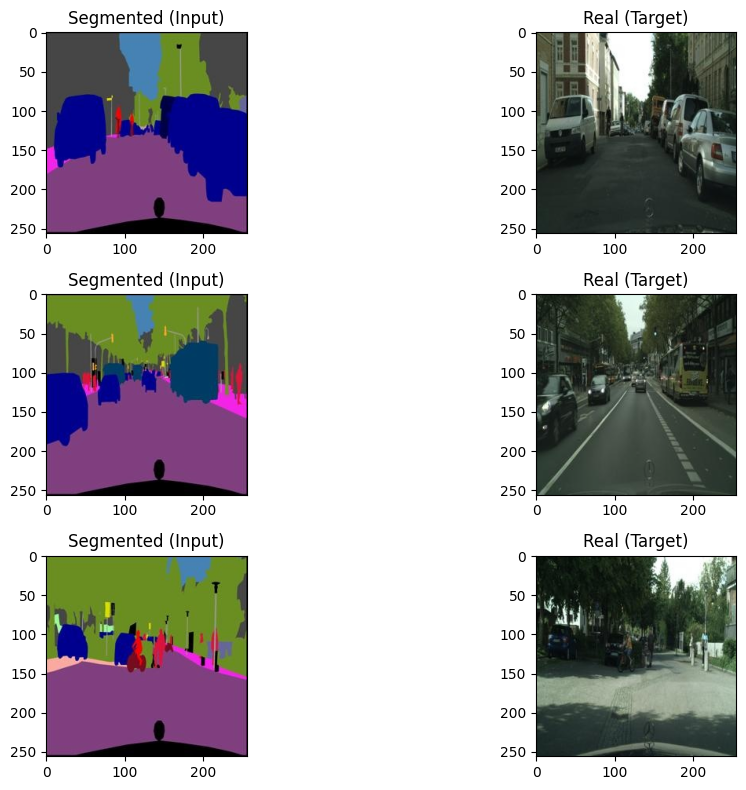

In [ ]:
import os
import random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

data_dir = 'cityscapes_pix2pix'  # Adjust according to your directory structure
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.files = sorted(os.listdir(root_dir))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        image = Image.open(img_path).convert('RGB')
        w, h = image.size
        w2 = w // 2
        input_image = image.crop((0, 0, w2, h))
        real_image = image.crop((w2, 0, w, h))

        if self.transform:
            input_image = self.transform(input_image)
            real_image = self.transform(real_image)

        return real_image, input_image


# Define transformations: resize and normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # [-1,1]
])

train_dataset = Pix2PixDataset(train_dir, transform=transform)
val_dataset = Pix2PixDataset(val_dir, transform=transform)

# Create DataLoaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)

# Show three samples from the training set
sample_iter = iter(train_loader)
input_imgs, target_imgs = next(sample_iter)

def denormalize(tensor):
    # Transform from [-1,1] to [0,1]
    return (tensor * 0.5) + 0.5

plt.figure(figsize=(12,8))
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.imshow(denormalize(input_imgs[i]).permute(1,2,0).cpu().numpy())
    plt.title("Segmented (Input)")

    plt.subplot(3,2,2*i+2)
    plt.imshow(denormalize(target_imgs[i]).permute(1,2,0).cpu().numpy())
    plt.title("Real (Target)")

plt.tight_layout()
plt.show()


# Pix2Pix Model Components

This cell defines the core components of the Pix2Pix model, including the DownSample, UpSample, and Discriminator classes. These components are essential for building the generator and discriminator networks used in the Pix2Pix framework.

## DownSample Class
The `DownSample` class is a custom PyTorch module that performs downsampling using a convolutional layer followed by optional batch normalization and a LeakyReLU activation function. It reduces the spatial dimensions of the input while increasing the number of channels.

### Constructor Parameters:
- `in_channels`: Number of input channels.
- `out_channels`: Number of output channels.
- `apply_norm`: Boolean flag to apply batch normalization.

### Forward Method:
- Takes an input tensor `x` and passes it through the defined layers sequentially.

## UpSample Class
The `UpSample` class is a custom PyTorch module that performs upsampling using a transposed convolutional layer followed by batch normalization, ReLU activation, and optional dropout. It increases the spatial dimensions of the input while reducing the number of channels.

### Constructor Parameters:
- `in_channels`: Number of input channels.
- `out_channels`: Number of output channels.
- `apply_dropout`: Boolean flag to apply dropout.

### Forward Method:
- Takes an input tensor `x` and passes it through the defined layers sequentially.

## Discriminator Class
The `Discriminator` class is a custom PyTorch module that defines the architecture of the discriminator network. The discriminator takes both the input image and the target/generated image as input and outputs a patch-based prediction indicating whether the input image is real or fake.

### Constructor Parameters:
- `in_channels`: Number of input channels (default is 3 for RGB images).

### Forward Method:
- Takes two input tensors `x` (input image) and `y` (target or generated image).
- Concatenates the inputs along the channel dimension.
- Passes the concatenated tensor through the defined layers sequentially to produce the output.

In [2]:
import torch
import torch.nn as nn

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_norm=True):
        super(DownSample, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=not apply_norm)]
        if apply_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, apply_dropout=False):
        super(UpSample, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2,
                               padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        # input is (input_image + target_image) so in_channels*2
        self.net = nn.Sequential(
            # (in_channels*2, 256, 256)
            nn.Conv2d(in_channels*2, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # (64, 128, 128)
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # (128, 64, 64)
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # (256, 32, 32)
            nn.Conv2d(256, 512, 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # (512, 31, 31)
            nn.Conv2d(512, 1, 4, 1, 1)
            # (1, 30, 30) patch output
        )

    def forward(self, x, y):
        # x: input image, y: target or generated image
        # concatenate along channel dimension
        combined = torch.cat([x, y], dim=1)
        return self.net(combined)


## Generator Class
The `Generator` class is a custom PyTorch module that defines the architecture of the generator network. The generator uses a U-Net architecture with downsampling and upsampling layers to transform the input image into the target image.

### Constructor Parameters:
- `in_channels`: Number of input channels (default is 3 for RGB images).
- `out_channels`: Number of output channels (default is 3 for RGB images).

### Forward Method:
- Takes an input tensor `x` and passes it through the downsampling layers to encode the input image.
- Passes the encoded features through the upsampling layers, concatenating the corresponding downsampled features to maintain spatial information.
- Produces the final output image using a transposed convolutional layer followed by a Tanh activation function.

In [3]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()
        
        # Encoder (DownSampling)
        self.down1 = DownSample(in_channels,64,apply_norm=False)   # (64, 128, 128)
        self.down2 = DownSample(64,128)                            # (128,64,64)
        self.down3 = DownSample(128,256)                           # (256,32,32)
        self.down4 = DownSample(256,512)                           # (512,16,16)
        self.down5 = DownSample(512,512)                           # (512,8,8)
        self.down6 = DownSample(512,512)                           # (512,4,4)
        self.down7 = DownSample(512,512)                           # (512,2,2)
        self.down8 = DownSample(512,512,apply_norm=False)          # (512,1,1)
        
        # Decoder (UpSampling)
        self.up1 = UpSample(512,512,apply_dropout=True)  # (512,2,2)
        self.up2 = UpSample(1024,512,apply_dropout=True)  # (512,4,4)
        self.up3 = UpSample(1024,512,apply_dropout=True)  # (512,8,8)
        self.up4 = UpSample(1024,512)                     # (512,16,16)
        self.up5 = UpSample(1024,256)                     # (256,32,32)
        self.up6 = UpSample(512,128)                      # (128,64,64)
        self.up7 = UpSample(256,64)                       # (64,128,128)
        
        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        # U-Net forward pass
        d1 = self.down1(x)    # (64,128,128)
        d2 = self.down2(d1)   # (128,64,64)
        d3 = self.down3(d2)   # (256,32,32)
        d4 = self.down4(d3)   # (512,16,16)
        d5 = self.down5(d4)   # (512,8,8)
        d6 = self.down6(d5)   # (512,4,4)
        d7 = self.down7(d6)   # (512,2,2)
        d8 = self.down8(d7)   # (512,1,1)
        
        u1 = self.up1(d8)
        u1 = torch.cat([u1,d7],dim=1)
        
        u2 = self.up2(u1)
        u2 = torch.cat([u2,d6],dim=1)
        
        u3 = self.up3(u2)
        u3 = torch.cat([u3,d5],dim=1)
        
        u4 = self.up4(u3)
        u4 = torch.cat([u4,d4],dim=1)
        
        u5 = self.up5(u4)
        u5 = torch.cat([u5,d3],dim=1)
        
        u6 = self.up6(u5)
        u6 = torch.cat([u6,d2],dim=1)
        
        u7 = self.up7(u6)
        u7 = torch.cat([u7,d1],dim=1)
        
        return self.final(u7)


## Loss Functions for Pix2Pix Model

In the Pix2Pix model, two primary loss functions are used to train the generator and discriminator networks: `criterion_GAN` and `criterion_L1`.

### GAN Loss (criterion_GAN)
The GAN loss is used to train both the generator and the discriminator. It is defined using the `nn.BCEWithLogitsLoss()` function, which combines a sigmoid layer and binary cross-entropy loss in a single class. This loss function is used to determine how well the discriminator can distinguish between real and fake images, and how well the generator can fool the discriminator.

```python
criterion_GAN = nn.BCEWithLogitsLoss()
```

### L1 Loss (criterion_L1)
The L1 loss, defined using the `nn.L1Loss()` function, is used to ensure that the generated images are close to the real images in terms of pixel values. This loss function calculates the mean absolute error between the generated image and the real image.

```python
criterion_L1 = nn.L1Loss()
```

### Discriminator Loss
The discriminator loss function calculates the loss for the discriminator network. It consists of two parts: the loss for real images and the loss for fake images. The real loss is calculated by comparing the discriminator's predictions on real images with a tensor of ones (indicating real). The fake loss is calculated by comparing the discriminator's predictions on fake images with a tensor of zeros (indicating fake). The total discriminator loss is the average of these two losses.


### Generator Loss
The generator loss function calculates the loss for the generator network. It consists of two parts: the GAN loss and the L1 loss. The GAN loss is calculated by comparing the discriminator's predictions on fake images with a tensor of ones (indicating real). The L1 loss is calculated by comparing the generated images with the real images. The total generator loss is the sum of the GAN loss and the L1 loss, weighted by a factor `lambda_L1`.


In [4]:
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

def discriminator_loss(D, real_input, real_target, fake_target):
    # Real
    real_preds = D(real_input, real_target)
    real_labels = torch.ones_like(real_preds, device=real_preds.device)
    real_loss = criterion_GAN(real_preds, real_labels)

    # Fake
    fake_preds = D(real_input, fake_target.detach())
    fake_labels = torch.zeros_like(fake_preds, device=fake_preds.device)
    fake_loss = criterion_GAN(fake_preds, fake_labels)

    D_loss = (real_loss + fake_loss)*0.5
    return D_loss

def generator_loss(D, real_input, fake_target, real_target, lambda_L1=100):
    # Fool the discriminator
    preds = D(real_input, fake_target)
    labels = torch.ones_like(preds, device=preds.device)
    GAN_loss = criterion_GAN(preds, labels)

    # L1 loss
    L1_loss = criterion_L1(fake_target, real_target)*lambda_L1

    G_loss = GAN_loss + L1_loss
    return G_loss, GAN_loss.item(), L1_loss.item()


## Training the Pix2Pix Model

This cell initiates the training process for the Pix2Pix model. The following steps are performed:

1. **Device Configuration**: The model is set to use GPU if available, otherwise it defaults to CPU.
    ```python
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ```

2. **Model Initialization**: The generator (`G`) and discriminator (`D`) models are instantiated and moved to the configured device.
    ```python
    G = Generator().to(device)
    D = Discriminator().to(device)
    ```

3. **Optimizer Setup**: Adam optimizers are created for both the generator and discriminator with a learning rate of `2e-4` and betas `(0.5, 0.999)`.
    ```python
    LR = 2e-4
    optimizer_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
    optimizer_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))
    ```

4. **Training Parameters**: The number of epochs is set to 50 and the L1 loss weight (`lambda_L1`) is set to 100.
    ```python
    EPOCHS = 50
    lambda_L1 = 100
    ```

5. **Logging**: Lists to store generator and discriminator losses during training.
    ```python
    G_losses = []
    D_losses = []
    ```

6. **Image Display Function**: A function `show_generated_images` is defined to visualize the input, generated, and real images during training.
    ```python
    def show_generated_images(model, loader):
        ...
    ```

7. **Training Loop**: The training loop iterates over the dataset for the specified number of epochs. For each batch:
    - The input and target images are moved to the configured device.
    - The generator produces fake images from the input images.
    - The discriminator is updated using the real and fake images.
    - The generator is updated to minimize the GAN and L1 losses.
    - Losses are logged for visualization.
    - Every 100 steps, the current losses are printed and sample images are displayed.
    ```python
    print("Starting Training...")
    step = 0
    for epoch in range(EPOCHS):
        for i, (inp, tgt) in enumerate(train_loader):
            ...
    print("Training Completed!")
    ```

This cell effectively sets up and executes the training process for the Pix2Pix model, logging the losses and displaying sample images at regular intervals.

Starting Training...
Epoch [1/51] Step [100] D_loss: 0.3130 G_loss: 21.9403
Epoch [1/51] Step [200] D_loss: 0.1051 G_loss: 22.2945
Epoch [1/51] Step [300] D_loss: 1.2667 G_loss: 23.0546
Epoch [1/51] Step [400] D_loss: 0.6286 G_loss: 24.7618
Epoch [1/51] Step [500] D_loss: 0.1895 G_loss: 23.4297
Epoch [1/51] Step [600] D_loss: 0.6406 G_loss: 20.8918
Epoch [1/51] Step [700] D_loss: 0.5560 G_loss: 23.4471


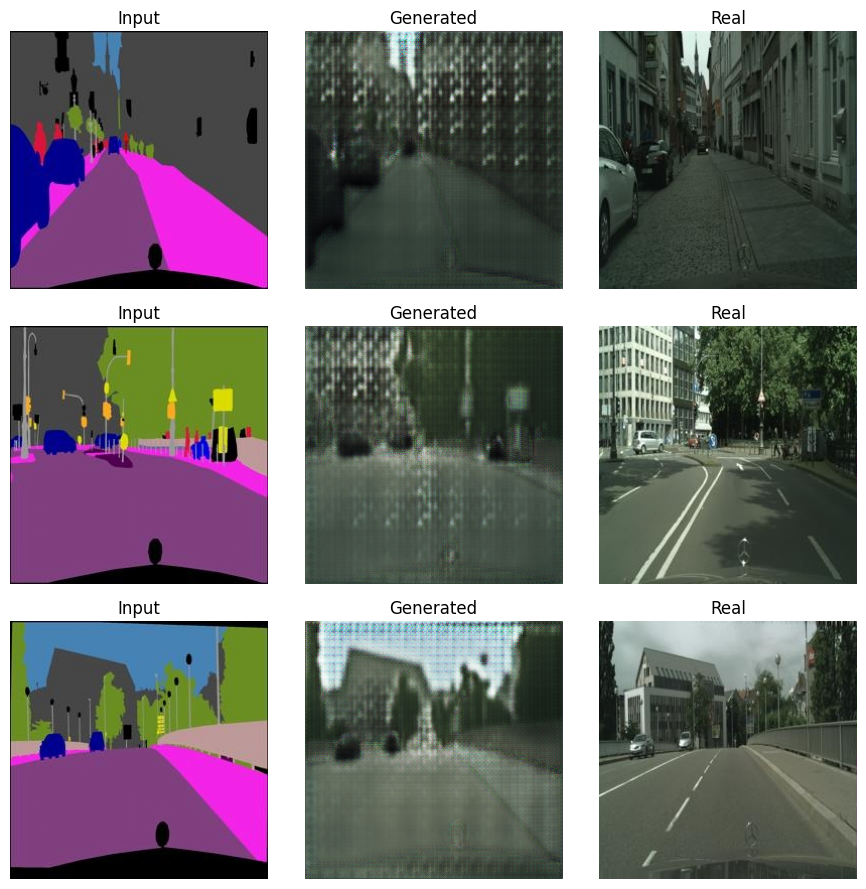

Epoch [2/51] Step [800] D_loss: 0.1463 G_loss: 27.2313
Epoch [2/51] Step [900] D_loss: 0.1924 G_loss: 24.4093
Epoch [2/51] Step [1000] D_loss: 0.2672 G_loss: 29.7878
Epoch [2/51] Step [1100] D_loss: 0.6214 G_loss: 20.3208
Epoch [2/51] Step [1200] D_loss: 0.4913 G_loss: 23.1774
Epoch [2/51] Step [1300] D_loss: 0.0847 G_loss: 25.7418
Epoch [2/51] Step [1400] D_loss: 0.5029 G_loss: 22.5306
Epoch [3/51] Step [1500] D_loss: 0.2605 G_loss: 25.5949
Epoch [3/51] Step [1600] D_loss: 0.2682 G_loss: 19.4867
Epoch [3/51] Step [1700] D_loss: 0.8929 G_loss: 16.6491
Epoch [3/51] Step [1800] D_loss: 0.1331 G_loss: 21.9457
Epoch [3/51] Step [1900] D_loss: 0.5540 G_loss: 19.3635
Epoch [3/51] Step [2000] D_loss: 0.9939 G_loss: 24.3784
Epoch [3/51] Step [2100] D_loss: 0.2867 G_loss: 26.7656
Epoch [3/51] Step [2200] D_loss: 0.2004 G_loss: 19.8705
Epoch [4/51] Step [2300] D_loss: 0.2709 G_loss: 26.0343
Epoch [4/51] Step [2400] D_loss: 1.4717 G_loss: 19.7839
Epoch [4/51] Step [2500] D_loss: 0.4358 G_loss: 20

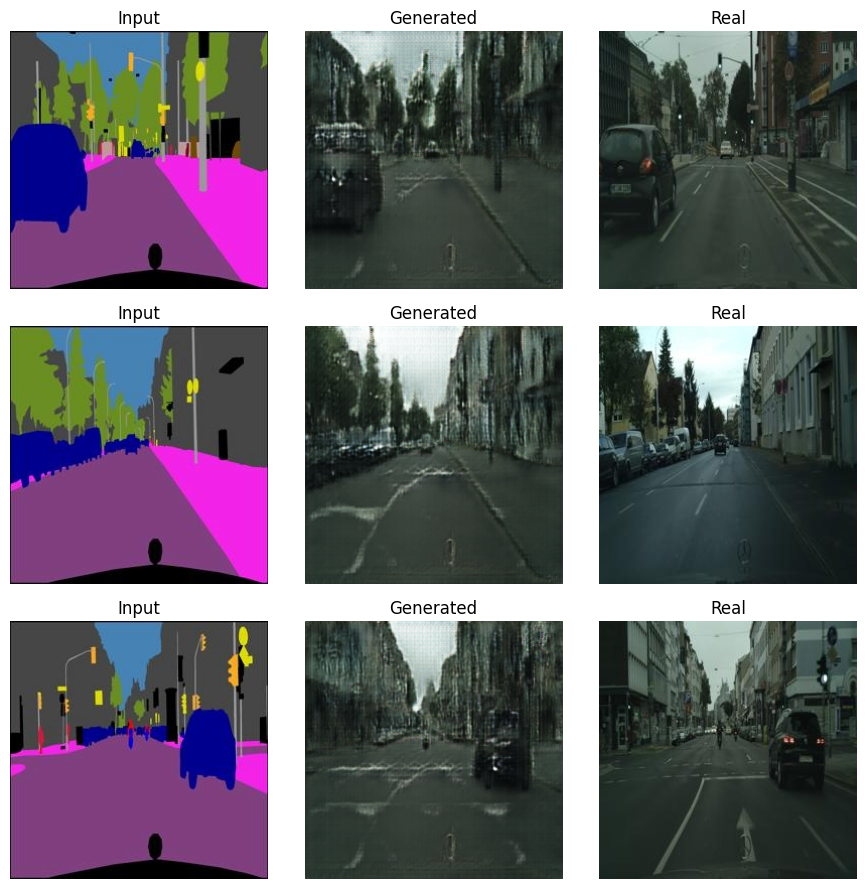

Epoch [12/51] Step [8200] D_loss: 0.9747 G_loss: 20.7140
Epoch [12/51] Step [8300] D_loss: 0.6367 G_loss: 23.2124
Epoch [12/51] Step [8400] D_loss: 0.4397 G_loss: 20.9174
Epoch [12/51] Step [8500] D_loss: 0.4449 G_loss: 18.4852
Epoch [12/51] Step [8600] D_loss: 0.3613 G_loss: 20.6746
Epoch [12/51] Step [8700] D_loss: 0.1819 G_loss: 22.8342
Epoch [12/51] Step [8800] D_loss: 0.1479 G_loss: 23.0041
Epoch [12/51] Step [8900] D_loss: 1.1771 G_loss: 16.1062
Epoch [13/51] Step [9000] D_loss: 0.2409 G_loss: 19.4492
Epoch [13/51] Step [9100] D_loss: 0.6218 G_loss: 22.1146
Epoch [13/51] Step [9200] D_loss: 0.7284 G_loss: 21.8218
Epoch [13/51] Step [9300] D_loss: 0.3044 G_loss: 21.0083
Epoch [13/51] Step [9400] D_loss: 0.5554 G_loss: 18.7074
Epoch [13/51] Step [9500] D_loss: 1.2751 G_loss: 16.0244
Epoch [13/51] Step [9600] D_loss: 0.2537 G_loss: 25.7182
Epoch [14/51] Step [9700] D_loss: 0.3527 G_loss: 23.4336
Epoch [14/51] Step [9800] D_loss: 0.2917 G_loss: 18.8095
Epoch [14/51] Step [9900] D_los

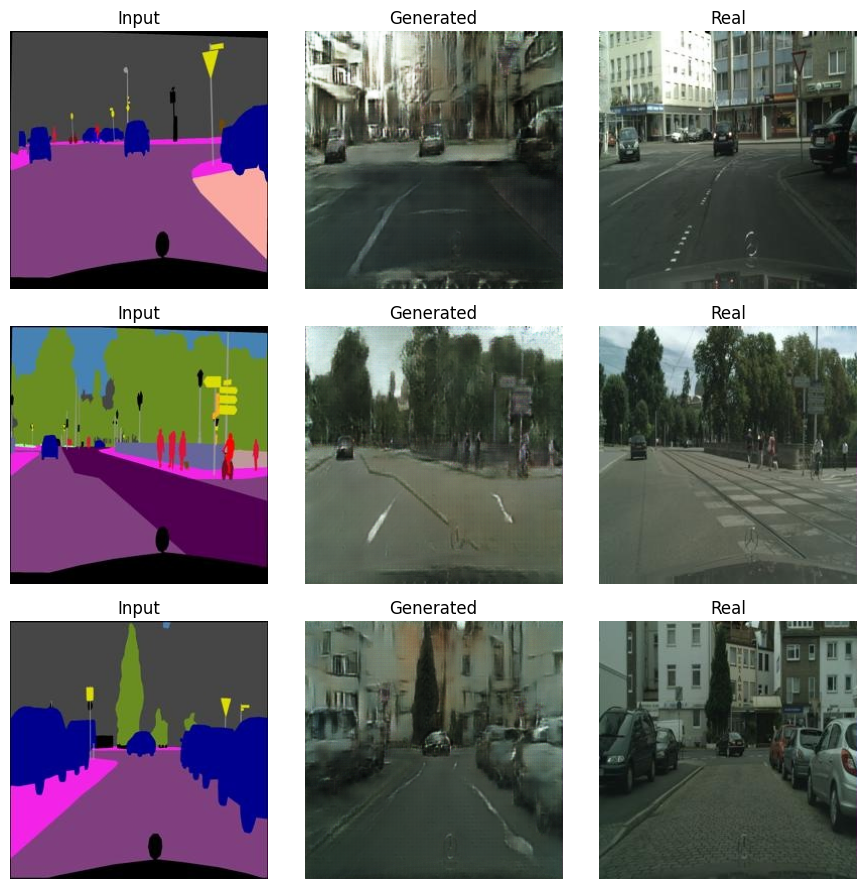

Epoch [22/51] Step [15700] D_loss: 0.4058 G_loss: 20.4394
Epoch [22/51] Step [15800] D_loss: 0.4146 G_loss: 16.6512
Epoch [22/51] Step [15900] D_loss: 0.1944 G_loss: 19.0352
Epoch [22/51] Step [16000] D_loss: 0.6847 G_loss: 13.9865
Epoch [22/51] Step [16100] D_loss: 0.3594 G_loss: 20.1602
Epoch [22/51] Step [16200] D_loss: 0.9671 G_loss: 15.2823
Epoch [22/51] Step [16300] D_loss: 0.6648 G_loss: 17.2205
Epoch [23/51] Step [16400] D_loss: 0.6129 G_loss: 15.7429
Epoch [23/51] Step [16500] D_loss: 0.2758 G_loss: 16.8979
Epoch [23/51] Step [16600] D_loss: 0.7576 G_loss: 15.3523
Epoch [23/51] Step [16700] D_loss: 0.3493 G_loss: 15.2967
Epoch [23/51] Step [16800] D_loss: 0.4718 G_loss: 18.4223
Epoch [23/51] Step [16900] D_loss: 0.5757 G_loss: 15.4251
Epoch [23/51] Step [17000] D_loss: 0.5736 G_loss: 16.2285
Epoch [23/51] Step [17100] D_loss: 0.3097 G_loss: 18.8567
Epoch [24/51] Step [17200] D_loss: 0.4041 G_loss: 13.2223
Epoch [24/51] Step [17300] D_loss: 0.9225 G_loss: 12.9315
Epoch [24/51] 

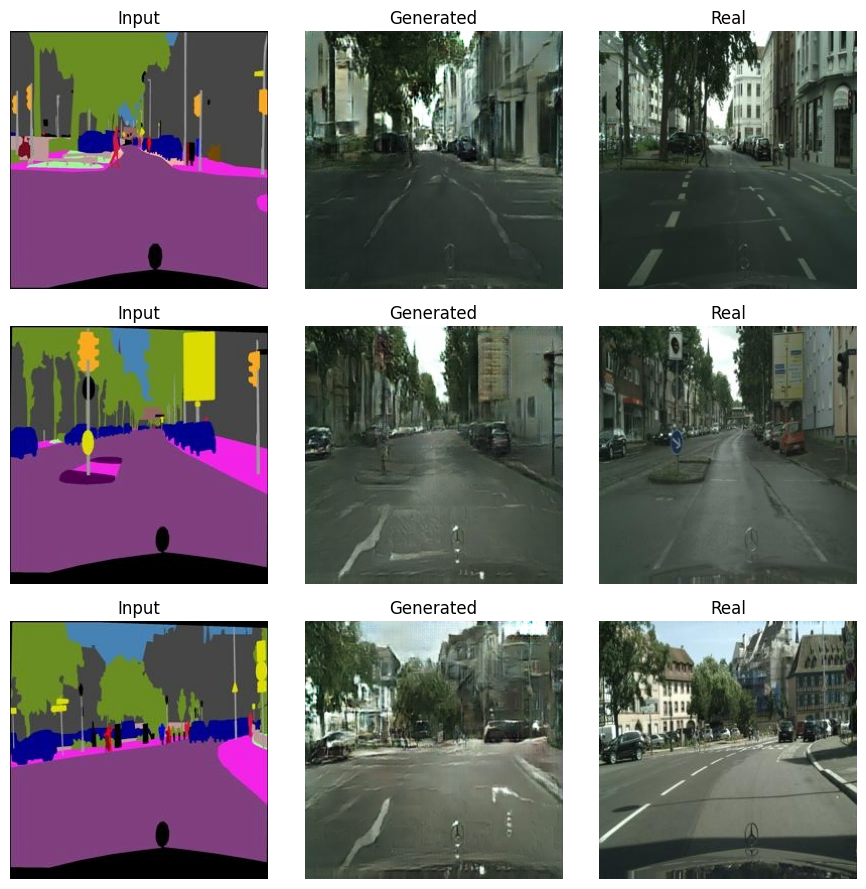

Epoch [32/51] Step [23100] D_loss: 1.2762 G_loss: 12.7206
Epoch [32/51] Step [23200] D_loss: 0.3196 G_loss: 15.6552
Epoch [32/51] Step [23300] D_loss: 0.7295 G_loss: 14.0320
Epoch [32/51] Step [23400] D_loss: 0.6532 G_loss: 17.4309
Epoch [32/51] Step [23500] D_loss: 0.3933 G_loss: 15.3947
Epoch [32/51] Step [23600] D_loss: 0.4145 G_loss: 15.1606
Epoch [32/51] Step [23700] D_loss: 0.7504 G_loss: 16.0499
Epoch [32/51] Step [23800] D_loss: 0.2932 G_loss: 16.2789
Epoch [33/51] Step [23900] D_loss: 0.3178 G_loss: 17.3944
Epoch [33/51] Step [24000] D_loss: 0.5840 G_loss: 12.4373
Epoch [33/51] Step [24100] D_loss: 0.2887 G_loss: 15.3437
Epoch [33/51] Step [24200] D_loss: 0.2800 G_loss: 16.4432
Epoch [33/51] Step [24300] D_loss: 0.8919 G_loss: 12.3689
Epoch [33/51] Step [24400] D_loss: 0.6035 G_loss: 13.0579
Epoch [33/51] Step [24500] D_loss: 0.4417 G_loss: 13.8171
Epoch [34/51] Step [24600] D_loss: 0.4143 G_loss: 12.9032
Epoch [34/51] Step [24700] D_loss: 0.6650 G_loss: 16.0235
Epoch [34/51] 

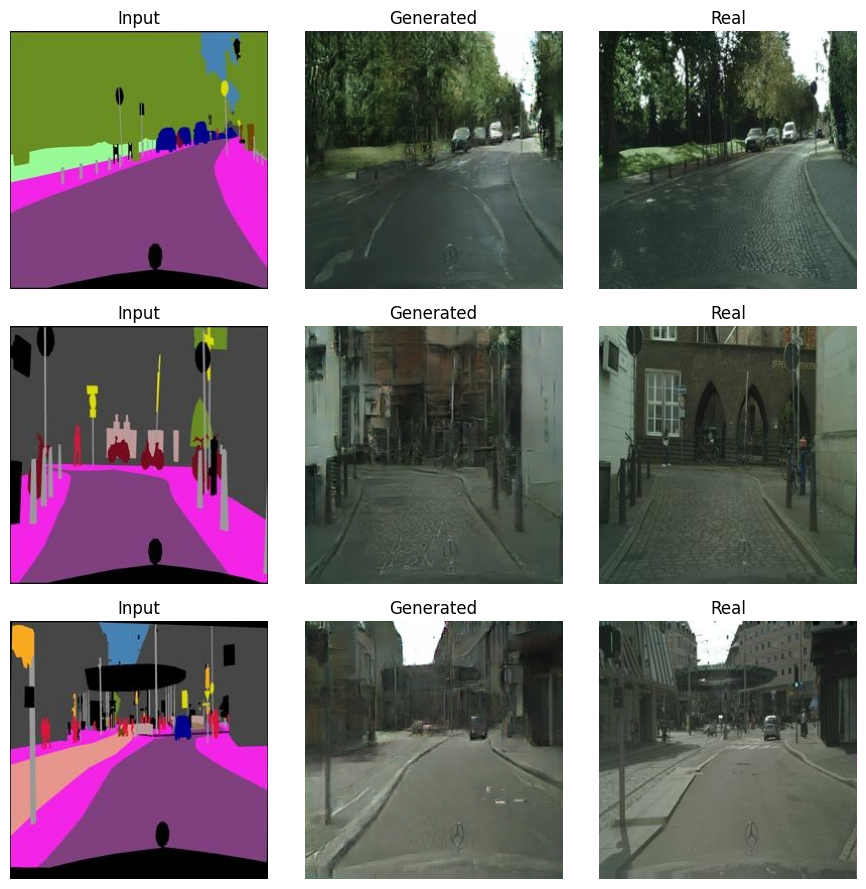

Epoch [42/51] Step [30600] D_loss: 0.4504 G_loss: 12.8105
Epoch [42/51] Step [30700] D_loss: 0.5322 G_loss: 14.0327
Epoch [42/51] Step [30800] D_loss: 0.2935 G_loss: 15.3410
Epoch [42/51] Step [30900] D_loss: 0.5216 G_loss: 13.8771
Epoch [42/51] Step [31000] D_loss: 0.2663 G_loss: 15.3910
Epoch [42/51] Step [31100] D_loss: 0.3891 G_loss: 14.6461
Epoch [42/51] Step [31200] D_loss: 0.4699 G_loss: 11.1847
Epoch [43/51] Step [31300] D_loss: 0.3453 G_loss: 12.8415
Epoch [43/51] Step [31400] D_loss: 0.4613 G_loss: 16.9928
Epoch [43/51] Step [31500] D_loss: 0.5715 G_loss: 11.7120
Epoch [43/51] Step [31600] D_loss: 0.3476 G_loss: 13.8111
Epoch [43/51] Step [31700] D_loss: 0.3620 G_loss: 14.7153
Epoch [43/51] Step [31800] D_loss: 0.8495 G_loss: 11.8487
Epoch [43/51] Step [31900] D_loss: 0.4184 G_loss: 12.1453
Epoch [44/51] Step [32000] D_loss: 0.4638 G_loss: 13.0570
Epoch [44/51] Step [32100] D_loss: 0.2154 G_loss: 15.5958
Epoch [44/51] Step [32200] D_loss: 0.5005 G_loss: 12.4597
Epoch [44/51] 

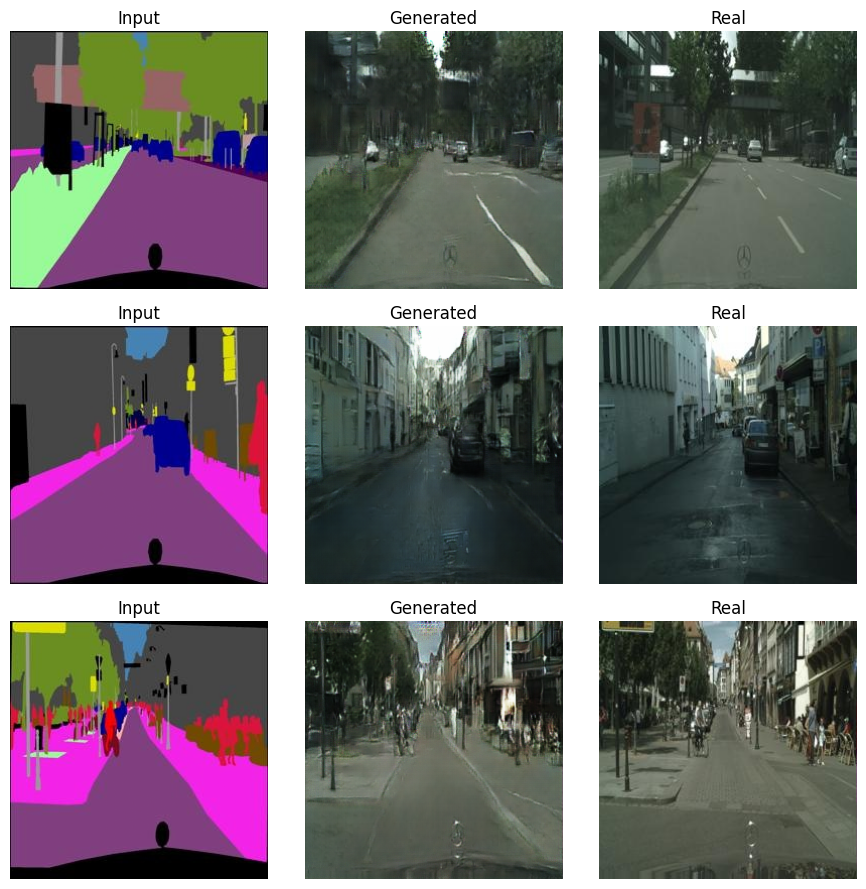

Training Completed!


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G = Generator().to(device)
D = Discriminator().to(device)

LR = 2e-4
optimizer_G = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

EPOCHS = 51
lambda_L1 = 100

# For logging
G_losses = []
D_losses = []

def show_generated_images(model, loader):
    model.eval()
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        fakes = model(inputs)
    model.train()

    # Display
    inputs = denormalize(inputs)
    targets = denormalize(targets)
    fakes = denormalize(fakes)

    fig, axes = plt.subplots(3,3,figsize=(9,9))
    for i in range(3):
        axes[i,0].imshow(inputs[i].permute(1,2,0).cpu().numpy())
        axes[i,0].set_title("Input")
        axes[i,0].axis('off')

        axes[i,1].imshow(fakes[i].permute(1,2,0).cpu().numpy())
        axes[i,1].set_title("Generated")
        axes[i,1].axis('off')

        axes[i,2].imshow(targets[i].permute(1,2,0).cpu().numpy())
        axes[i,2].set_title("Real")
        axes[i,2].axis('off')
    plt.tight_layout()
    plt.show()

print("Starting Training...")
step = 0
for epoch in range(EPOCHS):
    for i, (inp, tgt) in enumerate(train_loader):
        inp = inp.to(device)
        tgt = tgt.to(device)

        # Forward pass
        fake = G(inp)

        # Update D
        optimizer_D.zero_grad()
        D_loss = discriminator_loss(D, inp, tgt, fake)
        D_loss.backward()
        optimizer_D.step()

        # Update G
        optimizer_G.zero_grad()
        G_loss, g_adversarial, g_l1 = generator_loss(D, inp, fake, tgt, lambda_L1=lambda_L1)
        G_loss.backward()
        optimizer_G.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        step += 1
        if step % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}] Step [{step}] D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}")
            # Show some samples
    if epoch % 10 == 0:
        show_generated_images(G, train_loader)

print("Training Completed!")


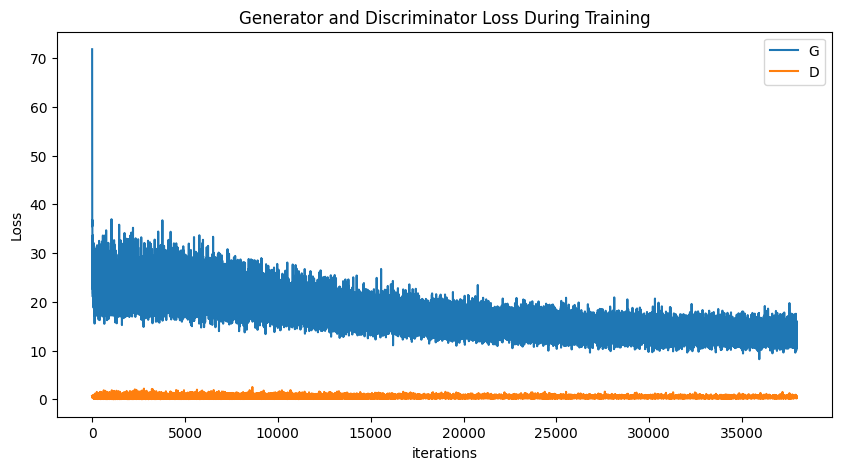

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


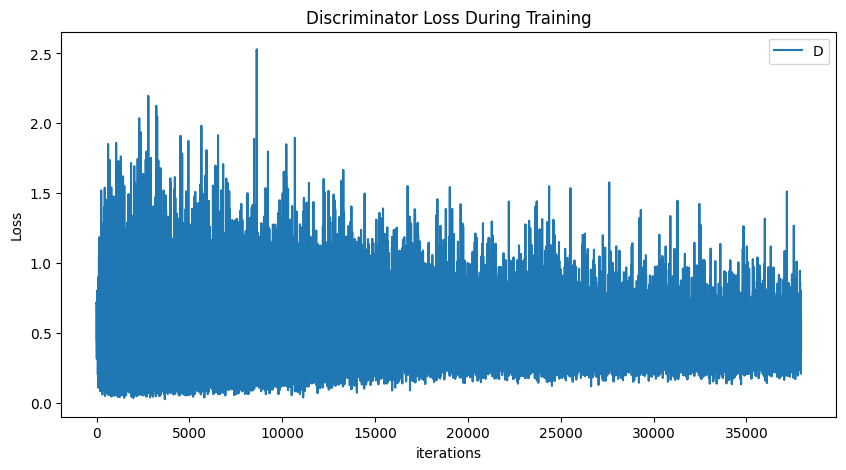

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

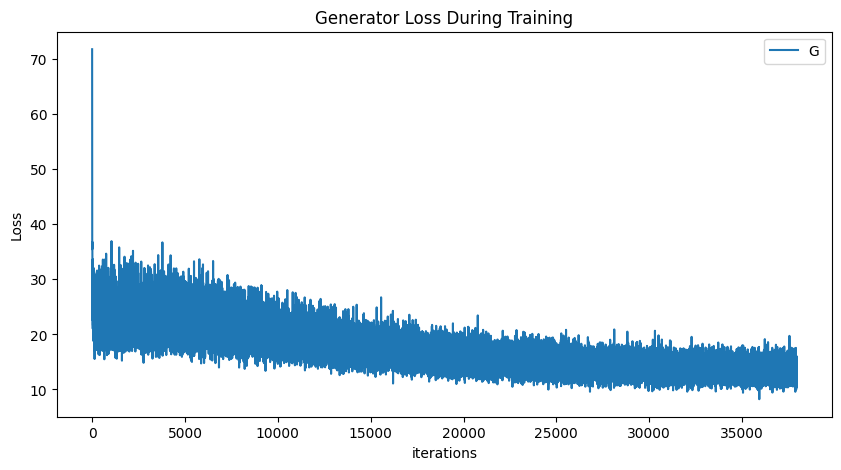

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses[2:], label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()